# **Analysis & Scoring of Amazon Product Reviews**
#### Abby Irish
#### Winter 2025

Implementation of various ML models and utilizing the Amazon product review dataset to focus on binary classification, multi-class classification, and clustering approaches to analyze and categorize product reviews.

In [94]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, 
    confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score
)
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt
%matplotlib inline

## **Part 1**: Binary Classification
#### Load the datasets and define the cutoff function

In [58]:
# Load the datasets
train_df = pd.read_csv('/Users/abigailirish/Desktop/CS74/Training.csv')
test_df = pd.read_csv("/Users/abigailirish/Desktop/CS74/Test.csv")

train_df.head()
test_df.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,True,"07 23, 2015",28EA11D68FB7FF05B5ABB5989B0EDDD2,2CC19105CB9E7E4C30B1A399F3BFA181,B468F2974AA56619CF81B9DB66277892,ordered 318c and receive the 303c. my bad. i d...,Wrong filter,1437609600,NaN,NaN,NaN,automotive
1,True,"11 14, 2016",465EF4B95F3C23F3D2E0DF032806B593,44FF14695671384604654465F32F51BE,B9CBF62E157F0A8798A4D33BA089CE2B,slime must have a serious manufacturing defect...,Don't waste your time on the compressor lottery.,1479081600,6.0,NaN,NaN,automotive
2,True,"12 8, 2016",139CE33FEE21437434272524E638F60B,FD46962FBDA48B8BCB6BCCDE86515E83,68A0EDEBA61ACC7DD4096275BBFA6C8A,while the description says will not produce an...,Not error free in 2012 Mini Countryman S ALL4,1481155200,NaN,NaN,NaN,automotive
3,True,"06 16, 2016",5FAB0AEBEEF467F40843E12D1AD2176C,B602B679B1EDBD9C59BC91802E521324,5C6E597BBBCACE38B3335C3D02CB0522,"this keys could not start my truck, after cutt...","This keys could not start my truck, after cutt...",1466035200,NaN,NaN,{'Color:': ' Black'},automotive
4,False,"12 3, 2016",EEEFD48788F090F22767829BD219B24C,DA059E333E0AF68256582317DBEDA711,50DDC9EE6BA5B5E97F77CDC57CC32EFD,kept on trickle charger when the hd was not ri...,Kept on trickle charger when the HD was not ri...,1480723200,NaN,NaN,NaN,automotive


In [59]:
# define cutoff function
# learning models in scikit-learn expect numerical labels for classification

def assign_label(rating, cutoff):
    return 1 if rating > cutoff else 0

### Feature extraction using 3 different methods

**Method 1: TF-IDF**

In [84]:
tfidf = TfidfVectorizer(min_df=10, max_df=0.8, sublinear_tf=False, use_idf=True)
X_train_tfidf = tfidf.fit_transform(train_df["reviewText"])

# train_df["verified"] = train_df["verified"].astype(int)  # Convert True/False to 1/0
# train_df["vote"] = train_df["vote"].fillna(0).astype(int)  # Fill NaNs with 0

# X_train_numeric = train_df[["verified", "vote"]].values

# X_train_combined = hstack((X_train_tfidf, X_train_numeric))

# print("Shape of TF-IDF features:", X_train_tfidf.shape)
# print("Shape of numeric features:", X_train_numeric.shape)
# print("Final combined feature shape:", X_train_combined.shape)

# # Define target variable
# y_train = train_df["label_cutoff_1"]  # Use the correct binary label column

# # Train Logistic Regression with combined features
# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X_train_combined, y_train)

# cutoff1_score_tfidf_multifeature = cross_val_score(log_reg, X_train_combined, y_train, cv=5, scoring="accuracy").mean()
# print(cutoff1_score_tfidf_multifeature)

**Method 2: CountVectorizer**

In [85]:
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(train_df["reviewText"])

**Method 3: HashingVectorizer**

In [86]:
hash_vectorizer = HashingVectorizer()
X_train_hash = hash_vectorizer.transform(train_df["reviewText"])

**Feature engineering**: adding a few features that may be relevant for the model and improve its performance

In [100]:
# # verified reviews may be more trustworthy
# train_df["verified"] = train_df["verified"].astype(int)  # Convert to 0 or 1

# # reviews with more helpful votes may be more representative of customer opinions
# train_df["vote"] = train_df["vote"].fillna(0)  # Fill missing values with 0
# train_df["vote"] = train_df["vote"].astype(int)  # Ensure integer type

# X_add_features = train_df[["verified", "vote"]].values

### **Cutoff = 1**

In [87]:
# apply a cutoff of 1
train_df["label_cutoff_1"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=1))
train_df.head() # inspect

y_train_cutoff1 = train_df["label_cutoff_1"]

#### Train the models, tune hyperparameters, and perform cross-fold validation
#### **Logistic Regression**

Hyperparameters to tune:
- C : controls regularization
- penalty : either the l1 or l2 norm
- solver : the optimization method

I am using a hyper-parameter grid to test different combinations of hyper-parameters with the RandomizedSearchCV function.

In [88]:
# function to evaluate model on the held-out validation set
def evaluate_model(y_true, y_pred, model_name):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

    # Determine if binary or multi-class classification
    is_multiclass = len(set(y_true)) > 2

    # Compute ROC AUC Score
    roc_auc = None
    if is_multiclass:
        roc_auc = metrics.roc_auc_score(y_true, y_pred, average="macro", multi_class="ovo")
    else:
        roc_auc = metrics.roc_auc_score(y_true, y_pred)

    print(f"\n{model_name} Performance on Validation Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc is not None else 'N/A'}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    metrics.ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Plot ROC Curve if binary
    if not is_multiclass:
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color="red", label="ROC Curve")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.grid(linestyle="--")
        plt.show()

In [121]:
# function to tune hyperparameters
def tune_model(X_train, y_train, X_val, y_val, vectorizer_name, model, param_grid):

    # if model is k-means, handle differently
    if isinstance(model, KMeans):
        best_score = -1
        best_model = None
        best_params = {}

        for n_clusters in param_grid["n_clusters"]:
            for init in param_grid["init"]:
                for max_iter in param_grid["max_iter"]:

                    kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter, n_init=10, random_state=42)
                    kmeans.fit(X_train)
                    cluster_labels = kmeans.predict(X_train)
                    ari_score = adjusted_rand_score(y_train, cluster_labels)

                    # Store Best Model
                    if ari_score > best_score:
                        best_score = ari_score
                        best_model = kmeans
                        best_params = {"n_clusters": n_clusters, "init": init, "max_iter": max_iter}

        print(f"\nBest Hyperparameters for K-Means ({vectorizer_name}): {best_params}")
        print(f"Best Adjusted Rand Index (ARI): {best_score:.4f}")

        y_val_clusters = best_model.predict(X_val)
        silhouette = silhouette_score(X_val, y_val_clusters)

        print(f"Silhouette Score on Validation Set: {silhouette:.4f}")
        return
    
    # else model is LR or SVM:
    scoring = {
        "AUC": "roc_auc",
        "Accuracy": make_scorer(accuracy_score),
        "Macro F1": make_scorer(f1_score, average="macro")
    }

    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit="Macro F1",
        n_jobs=-1,
        return_train_score=True,
    )

    gs.fit(X_train, y_train)
    
    best_model = gs.best_estimator_
    best_model.fit(X_train, y_train)

    y_val_pred = best_model.predict(X_val)

    print(f"\nBest Hyperparameters for {vectorizer_name}: {gs.best_params_}")
    print(f"Best Macro F1 Score: {gs.best_score_:.4f}")
    evaluate_model(y_val, y_val_pred, f"{model.__class__.__name__} ({vectorizer_name})")



Best Hyperparameters for TF-IDF: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7076

LogisticRegression (TF-IDF) Performance on Validation Set:
Accuracy: 0.8344
Macro F1 Score: 0.7200
ROC AUC: 0.698135951877125


<Figure size 600x500 with 0 Axes>

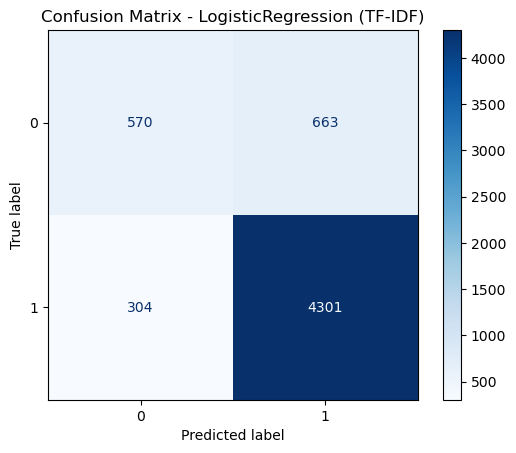

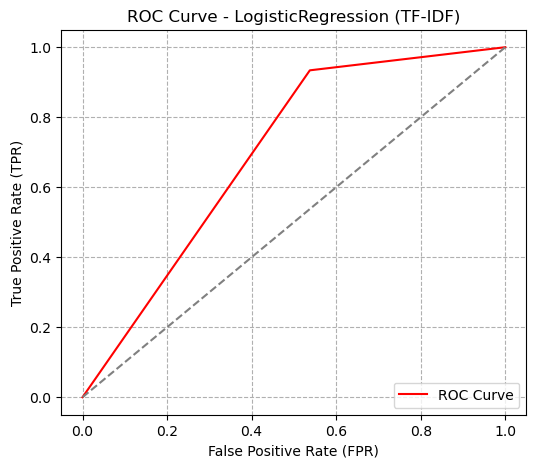

In [92]:
# tune tfidf LR hyperparameters
lr_param_grid = {
    "C": [0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100],  
    "penalty": ["l2"],  
    "solver": ["lbfgs", "saga"]
}

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, "TF-IDF", LogisticRegression(max_iter=5000), lr_param_grid)


Best Hyperparameters for CountVectorizer: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7054

LogisticRegression (CountVectorizer) Performance on Validation Set:
Accuracy: 0.8356
Macro F1 Score: 0.7207
ROC AUC: 0.6980051831950356


<Figure size 600x500 with 0 Axes>

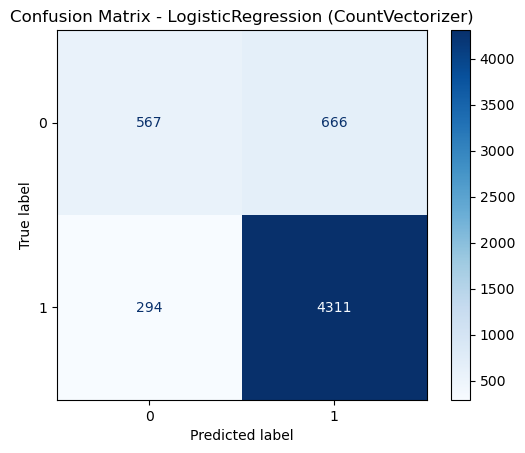

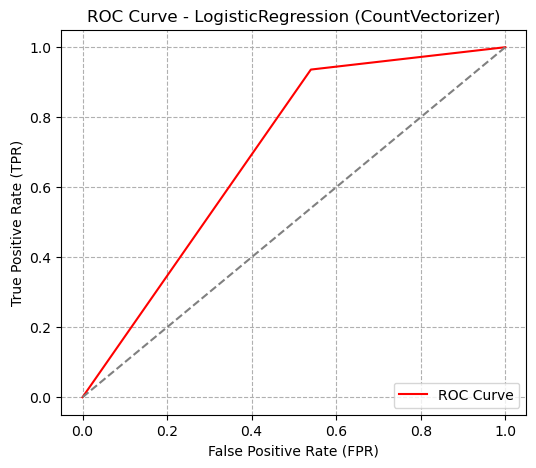

In [93]:
# tune CountVectorizer LR hyperparameters
lr_param_grid = {
    "C": [0.1, 1, 10],  
    "penalty": ["l2"],  
    "solver": ["lbfgs", "saga"]
}

X_train_count_sub, X_val_count, y_train_sub, y_val = train_test_split(
    X_train_count, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_count_sub, y_train_sub, X_val_count, y_val, "CountVectorizer", LogisticRegression(max_iter=5000), lr_param_grid)


Best Hyperparameters for HashingVectorizer: {'C': 25, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7100

LogisticRegression (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.8369
Macro F1 Score: 0.7226
ROC AUC: 0.6994676790011914


<Figure size 600x500 with 0 Axes>

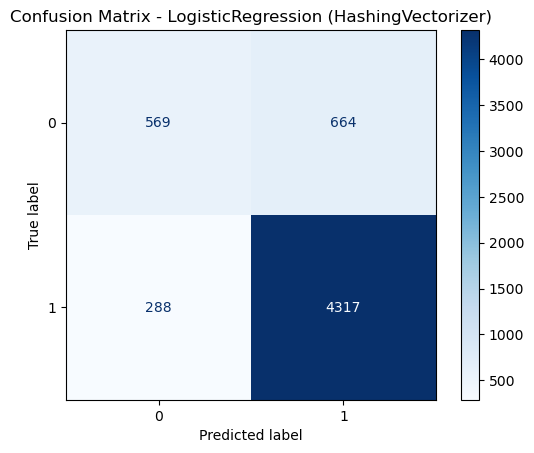

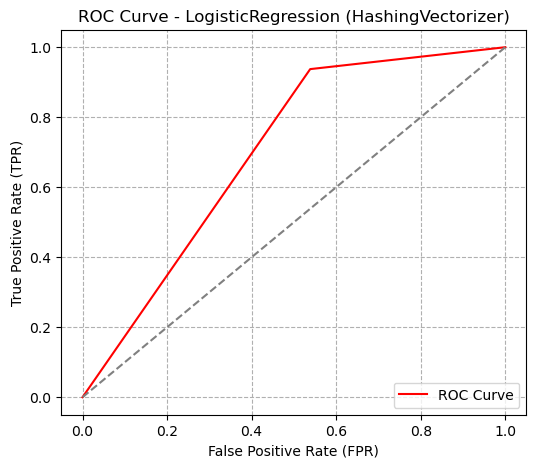

In [96]:
# tune HashingVectorizer LR hyperparameters
lr_param_grid = {
    "C": [0.1, 1.5, 5, 15, 16, 25, 50],  # Regularization strength
    "penalty": ["l2"],  # L1/L2 Regularization
    "solver": ["saga"]
}

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, "HashingVectorizer", LogisticRegression(max_iter=5000), lr_param_grid)

#### Logistic Regression cutoff = 1 best model: HashingVectorizer LR model
##### hyperparameters: C = 16, penalty = l2, solver = saga
using the l1 regularization provides slightly better results than the l2 regulizer
The 'saga' solver 


#### **Support Vector Machine**
note: not using CountVectorizer feature extraction method any more because of long run-time without getting better performance

In [114]:
svm_param_grid = {
    "C": [1],  # Regularization strength
    "kernel": ["linear"],  # linear kernel for text data
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for TF-IDF: {'C': 1, 'kernel': 'linear'}
Best Macro F1 Score: 0.6247

SVC (TF-IDF) Performance on Validation Set:
Accuracy: 0.7232
Macro F1 Score: 0.6121
ROC AUC: 0.6214333832631938


<Figure size 600x500 with 0 Axes>

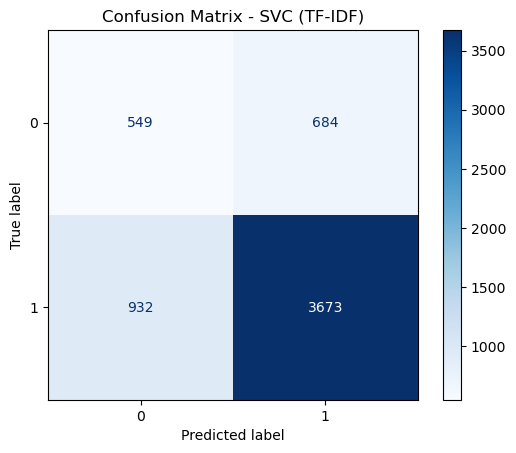

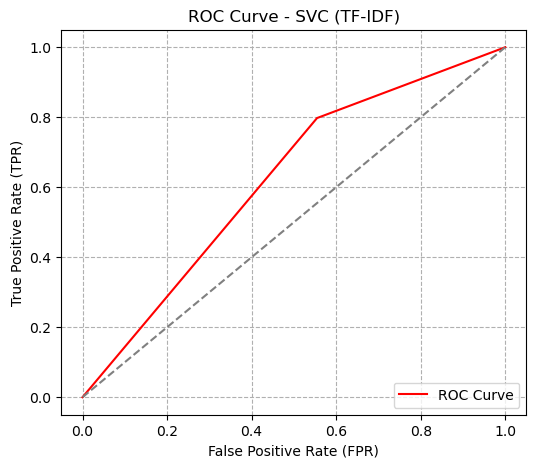

In [115]:
# tfidf
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, "TF-IDF", SVC(max_iter=1000), svm_param_grid)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for HashingVectorizer: {'C': 1, 'kernel': 'linear'}
Best Macro F1 Score: 0.5754

SVC (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7162
Macro F1 Score: 0.5770
ROC AUC: 0.5774890299605581


<Figure size 600x500 with 0 Axes>

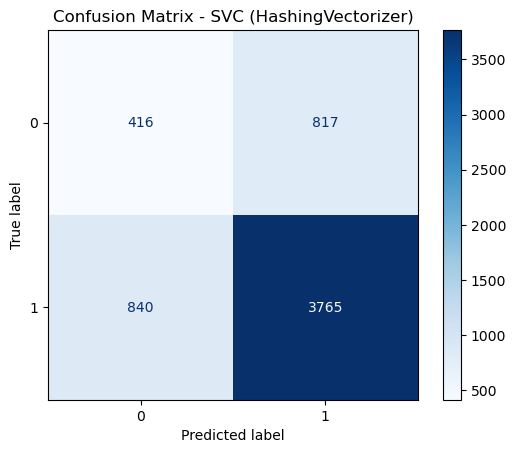

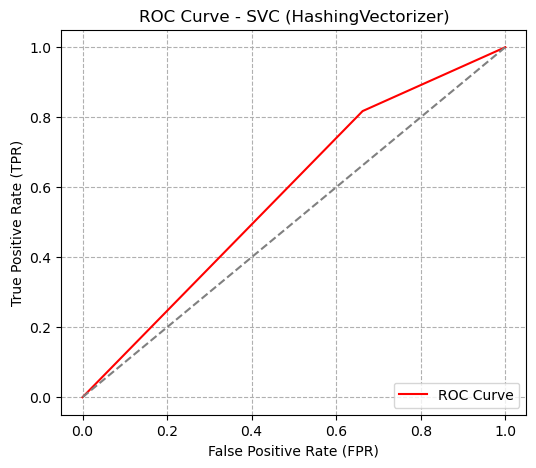

In [117]:
# HashingVectorizer
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, "HashingVectorizer", SVC(max_iter=1000), svm_param_grid)

#### **K-Means Clustering**

In [125]:
kmeans_param_grid = {
    "n_clusters": [2, 10, 15],  
    "init": ["k-means++", "random"],  
    "max_iter": [10, 300, 500]
}

In [126]:
# tfidf
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, "TF-IDF", KMeans(), kmeans_param_grid)


Best Hyperparameters for K-Means (TF-IDF): {'n_clusters': 15, 'init': 'random', 'max_iter': 10}
Best Adjusted Rand Index (ARI): 0.0003
Silhouette Score on Validation Set: 0.0006


In [ ]:
# Hashing Vectorizer
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, "HashingVectorizer", KMeans(), kmeans_param_grid)

##### Cutoff 1 best model: 

Test on kaggle dataset

In [26]:
# Transform test reviews using the best-performing feature extraction method
X_test_tfidf = tfidf.transform(test_df["reviewText"])  # If TF-IDF was best

# Use the trained model to predict
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'binary_split_1': y_pred_tfidf})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

# # Save the predictions file
test_submission.to_csv("test_submission_part_1.csv", index=False)

print("Submission file saved: test_submission_part_1.csv")

(4500, 2)
Submission file saved: test_submission_part_1.csv


#### **Cutoff = 2**

In [135]:
train_df["label_cutoff_2"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=2))
train_df.head() # inspect

y_train_cutoff2 = train_df["label_cutoff_2"]

#### **Logistic Regression:**

#### **Support-Vector Machine:**

#### **K-Means Clustering:**

### **Cutoff = 3**

### **Cutoff = 4**

### **Cutoff = 5**

## Binary Classification Report:

I tested the three feature extraction methods, finding that Count Vectorizer was much more computationally expensive without providing better accuracy than the other two. 

I used the l2 regulizer, as l1 took much more run-time without providing better accuracy. I found that the best C parameter changed depending on the type of classifier. For logistic regression with the tfidf extraction method, the optimal C value was 10, whereas for the HashingVectorizer method the optimal C value was 25. For 